In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter

In [32]:
train = pd.read_csv('Train.csv.zip', compression='zip')
test = pd.read_csv('Test.csv.zip', compression='zip')
train.columns

Index(['id', 'date', 'street_id', 'build_tech', 'floor', 'area', 'rooms',
       'balcon', 'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3',
       'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12',
       'kw13', 'price'],
      dtype='object')

In [33]:
# Save the 'Id' column
train_ID = train['id']
test_ID = test['id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

In [34]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (100000, 24)
Test data size is : (100000, 23)
Combined dataset size is : (200000, 23)


/home/axreldable/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [35]:
# настройка параметров
all_data[['build_tech']] = all_data[['build_tech']].replace(np.nan, 0.5)
all_data[['metro_dist']] = all_data[['metro_dist']].replace(np.nan, 15.0)

In [36]:
all_data.drop("g_lift", axis = 1, inplace = True)
all_data.drop("street_id", axis = 1, inplace = True)
all_data.drop("date", axis = 1, inplace = True)
all_data.drop("kw1", axis = 1, inplace = True)
all_data.drop("kw2", axis = 1, inplace = True)
all_data.drop("kw3", axis = 1, inplace = True)
all_data.drop("kw4", axis = 1, inplace = True)
all_data.drop("kw5", axis = 1, inplace = True)
all_data.drop("kw6", axis = 1, inplace = True)
all_data.drop("kw7", axis = 1, inplace = True)
all_data.drop("kw8", axis = 1, inplace = True)
all_data.drop("kw9", axis = 1, inplace = True)
all_data.drop("kw10", axis = 1, inplace = True)
all_data.drop("kw11", axis = 1, inplace = True)
all_data.drop("kw12", axis = 1, inplace = True)
all_data.drop("kw13", axis = 1, inplace = True)

In [37]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [38]:
all_data
all_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
area          200000 non-null int64
balcon        200000 non-null int64
build_tech    200000 non-null float64
floor         200000 non-null int64
metro_dist    200000 non-null float64
n_photos      200000 non-null int64
rooms         200000 non-null int64
dtypes: float64(2), int64(5)
memory usage: 10.7 MB



 mu = 15.13 and sigma = 0.68



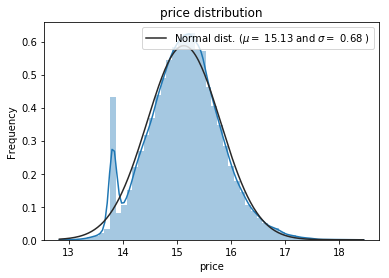

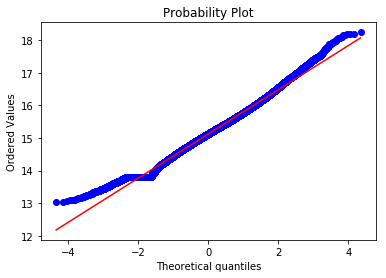

Skewness: 0.127139
Kurtosis: 0.122251


In [39]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

y_train = train.price.values

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

In [40]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
area,3.050215
floor,1.665184
balcon,0.954434
build_tech,0.665679
n_photos,0.567549
rooms,0.055912
metro_dist,-0.615003


In [41]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 7 skewed numerical features to Box Cox transform


In [43]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [49]:
y_train.shape

(100000, 7)

In [145]:
# X.shape

In [51]:
# это только для подбора параметров

clf = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10000, random_state=0)
kf = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_absolute_error)
scores = sklearn.model_selection.cross_val_score(clf, train, y_train, scoring=scorer, cv=kf)
print(scores)
print(scores.mean(), scores.std())

# [0.36920096 0.36588502 0.36571012]
# 0.3669320318613996 0.0016059614409274633

In [63]:
clf = sklearn.ensemble.GradientBoostingRegressor(n_estimators=17500, random_state=0)
kf = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_absolute_error)
scores = sklearn.model_selection.cross_val_score(clf, train, y_train, scoring=scorer, cv=kf)
print(scores)
print(scores.mean(), scores.std())

# [0.37162186 0.36812795 0.36817486]
# 0.3693082207915419 0.0016360990627752722

[0.37162186 0.36812795 0.36817486]
0.3693082207915419 0.0016360990627752722


In [66]:
X, Xt, y, yt = sklearn.model_selection.train_test_split(train, y_train, test_size=0.3, random_state=0)

In [67]:
# clf_gbm_100 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, random_state=0)
# clf_gbm_1000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000, random_state=0) # 1039250
# clf_gbm_5000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=5000, random_state=0) # 706501
# clf_gbm_7500 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=7500, random_state=0) # 684244
clf_gbm_10000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10000, random_state=0) # 675663
# clf_gbm_15000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=15000, random_state=0) # 671288
# clf_gbm_17500 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=17500, random_state=0) # 670816
# clf_gbm_25000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=25000, random_state=0) # 672847
# clf_gbm_42500 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=42500, random_state=0) # 680505
# clf_gbm_50000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=50000, random_state=0) # 684699
# clf_gbm_75000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=75000, random_state=0) # 697975
# clf_gbm_100000 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100000, random_state=0)

clf_gbm_10000.fit(X, y)

pred_gbm_10000 = clf_gbm_10000.predict(Xt)

score_gbm_10000 = sklearn.metrics.mean_absolute_error(yt, pred_gbm_10000)

print('Score Gradient Boosting 10000: %s' % (score_gbm_10000))

Score Gradient Boosting 10000: 0.3695049797783601


In [84]:
score_gbm_10000 = sklearn.metrics.mean_absolute_error(np.expm1(yt), np.expm1(pred_gbm_10000))

print('Score Gradient Boosting 10000: %s' % (score_gbm_10000))

Score Gradient Boosting 10000: 1676091.30536175


In [68]:
clf_gbm_10000.fit(train, y_train)

pred = clf_gbm_10000.predict(test)

In [70]:
pred_old = pred
pred_new = np.expm1(pred_old)
pred_new

array([ 3144393.79059227,  2442017.5120132 ,  2917471.50440742, ...,
        5527994.88709401,  2926002.15954253, 11069570.04730394])

In [79]:
test_ID.values

array([100000, 100001, 100002, ..., 199997, 199998, 199999])

In [81]:
test['price'] = pred_new
test['id'] = test_ID.values
test
test[['id', 'price']].to_csv('sub.csv', index=False)

/home/axreldable/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/axreldable/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
